# Задача классификации текста


In [ ]:
!pip install youtokentome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for youtokentome: filename=youtokentome-1.0.6-cp310-cp310-linux_x86_64.whl size=1951496 sha256=9ea2f8c205aa03c871431ce274c310bfda0b9c562985f8d1d0b241d2b3298436
  Stored in directory: /root/.cache/pip/wheels/df/85/f8/301d2ba45f43f30bed2fe413efa760bc726b8b660ed9c2900c
Successfully built youtokentome


In [ ]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 36.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningModule
from torch import nn, optim
from pytorch_lightning import Trainer


from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from random import choice
from typing import Union

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer
import spacy
import youtokentome as yttm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Подготовка данных

Загрузим предоставленные нам [данные](https://drive.google.com/drive/folders/1Df8XPJNz2k2O8K_7NJ9hPBceRB6oa8gB) и взглянем на них:

In [ ]:
data = pd.read_csv('train_spam.csv')

In [ ]:
len(data)

16278

In [ ]:
data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


У нас нет численного признака принадлежности сообщения к спаму, поэтому введем его сами:

In [ ]:
data['target'] = data.apply(lambda x: x['text_type'] == 'spam', axis=1).astype(int)

In [ ]:
data.head()

,text_type,text,target
0,ham,make sure alex knows his birthday is over in f...,0
1,ham,a resume for john lavorato thanks vince i will...,0
2,spam,plzz visit my website moviesgodml to get all m...,1
3,spam,urgent your mobile number has been awarded wit...,1
4,ham,overview of hr associates analyst project per ...,0


Сразу разделим датасет на `train`, `val` и `test`:

In [ ]:
train, val_test = train_test_split(data, test_size=0.2,
                                          random_state=42)

In [ ]:
val, test = train_test_split(val_test, test_size=0.5, random_state=42)

Для начала нужно будет токенизировать данные. Возьмем BPE, для его обучения я взяла оптимальный словарь в 5 000 слов и покрытие 0.999:

In [ ]:
class MyTokenizer:
    def __init__(self):
        self.tokenizer = WordPunctTokenizer()
    def tokenize(self, text):
        tokens = self.tokenizer.tokenize(text.lower())
        return [word for word in tokens if word not in stopwords.words('english')]

class BPETokenizer:
  def __init__(self):
    self.tokenizer = yttm.BPE.train('train_spam.csv', 'bpe_model.tsv', vocab_size=5000, coverage=0.999)
    self.word_punct = MyTokenizer()
  def tokenize(self, text):
    text = ' '.join(self.word_punct.tokenize(text))
    return self.tokenizer.encode(text)

In [ ]:
tokenizer = BPETokenizer()

In [ ]:
SOS_TOKEN = '[SOS]'
EOS_TOKEN = '[EOS]'
PAD_TOKEN = '[PAD]'
UNK_TOKEN = '[UNK]'

vocabulary = set([SOS_TOKEN, EOS_TOKEN, PAD_TOKEN, UNK_TOKEN])
texts_size = []

In [ ]:
def tokenize_text(data):
  tokenized_texts = list()
  for text in tqdm(data['text']):
    # Токенизируем текст
    tokenized_text = tokenizer.tokenize(text.lower())
    tokenized_text = [SOS_TOKEN] + tokenized_text + [EOS_TOKEN]

    # Обновим словарь
    for token in tokenized_text:
        vocabulary.add(token)

    # Добавим токенизированный текст в датасет
    tokenized_texts.append(tokenized_text)
    texts_size.append(len(tokenized_text))
  return tokenized_texts

In [ ]:
train_tokenized_texts = tokenize_text(train)
val_tokenized_texts = tokenize_text(val)
test_tokenized_texts = tokenize_text(test)

vocab_size = len(vocabulary)

  0%|          | 0/13022 [00:00<?, ?it/s]

  0%|          | 0/1628 [00:00<?, ?it/s]

  0%|          | 0/1628 [00:00<?, ?it/s]

In [ ]:
print(f"Vocabulary size is {vocab_size}")
print(f"Tokenized example: {choice(train_tokenized_texts)}")

Vocabulary size is 4856
Tokenized example: ['[SOS]', 815, 829, 786, 1109, 4811, 1006, 829, 786, 930, 4507, 1492, 1137, 807, 4279, 854, 2104, 1912, 2744, 1825, 961, 815, 829, 786, 1496, 715, 1137, 2088, 1825, 1752, 834, 773, 924, 829, 786, 773, 2136, 3892, 1535, 2437, 1046, 697, 961, 740, 871, 2810, 1535, 1213, 3888, 815, 829, 786, 1496, 1973, 3514, 825, 1195, 903, 1114, 1875, 930, 1142, 1600, 1212, 12, 2027, 2800, 953, 829, 786, 1496, 4806, 1648, 3993, 930, 1142, 1600, 2090, 3351, 1304, 2183, 3802, 829, 786, 1496, 733, 773, 12, 15, 784, 829, 786, 3301, 1099, 1479, 2753, 1498, 751, 1496, 1634, 3802, 829, 786, 733, 1437, 3175, 829, 786, 710, 743, '[EOS]']


In [ ]:
id_to_token = list(vocabulary) # id_to_token[i] -> token_i
token_to_id = {token: id for id, token in enumerate(id_to_token)} # token_i -> i

In [ ]:
class TextsForLM(Dataset):
    def __init__(self, texts):
        self.texts = list()

        for text in tqdm(texts):
            text_ids = [token_to_id.get(token, token_to_id[UNK_TOKEN]) for token in text]

            self.texts.append(text_ids)

    def __getitem__(self, index):
        return self.texts[index]

    def __len__(self):
        return len(self.texts)

Посмотрим, как распределена длина токенизированных текстов.

In [ ]:
X_train = TextsForLM(train_tokenized_texts)
X_val = TextsForLM(val_tokenized_texts)
X_test = TextsForLM(test_tokenized_texts)

  0%|          | 0/13022 [00:00<?, ?it/s]

  0%|          | 0/1628 [00:00<?, ?it/s]

  0%|          | 0/1628 [00:00<?, ?it/s]

<BarContainer object of 108 artists>

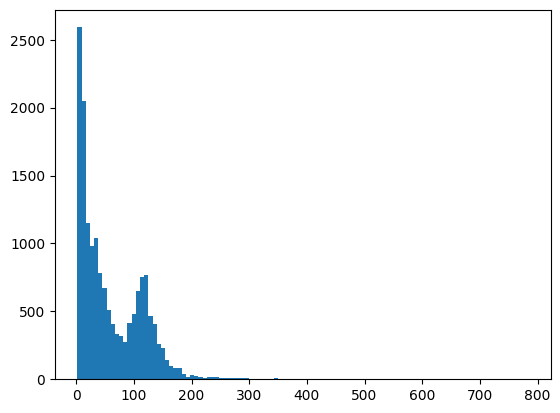

In [ ]:
%matplotlib inline

_, _, hist = plt.hist(texts_size, bins='auto')
hist

Видно, что если мы возьмем размер вектора 200, этого будет достаточно.

In [ ]:
max_length = 200

def collate_texts(texts):
    data = torch.full((len(texts), max_length), token_to_id[PAD_TOKEN])
    # Каждая строка матрицы -- один текст.
    # Токены каждого текста пронумерованы с помощью token_to_id, нам остается только взять первые max_length токенов
    # Если текст короче max_text_len, оставляем соответствующие ячейки id PAD_TOKEN
    for i, text in enumerate(texts):
      for j, word in enumerate(text):
        if j == max_length:
          break
        data[i][j] = word
    return torch.LongTensor(data)

In [ ]:
X_train = collate_texts(X_train)
X_val = collate_texts(X_val)
X_test = collate_texts(X_test)

In [ ]:
class SpamDataset(Dataset):
    def __init__(self, X, y) -> None:
        super().__init__()
        self.X = torch.tensor(X, dtype=torch.int)
        self.y = torch.tensor(y.values, dtype=torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index].unsqueeze(0)

In [ ]:
train_dataset = SpamDataset(X_train, train['target'])
val_dataset  = SpamDataset(X_val, val['target'])
test_dataset = SpamDataset(X_test, test['target'])

<ipython-input-25-297bcd7670e6>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.int)


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
next(iter(train_dataloader))

[tensor([[4853,  716,   22,  ..., 2452, 2452, 2452],
         [4853,  928, 1426,  ..., 2452, 2452, 2452],
         [4853, 1215,   16,  ..., 2452, 2452, 2452],
         ...,
         [4853,  925,  943,  ..., 2452, 2452, 2452],
         [4853,    1, 3987,  ..., 2452, 2452, 2452],
         [4853,    1,    0,  ..., 2452, 2452, 2452]], dtype=torch.int32),
 tensor([[0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
  

## Базовая модель

Попробую самую простую модель, линейный слой надо слоем эмбеддингов.

In [ ]:
class EmbeddingMean(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.mean(1)

In [ ]:
avg_train_losses = []
avg_val_losses = []
train_losses = []
val_losses = []
score = []


class LMModel(LightningModule):
    def __init__(self, vocab_size, emb_dim=128):
        super().__init__()
        self.model = nn.Sequential(
    nn.Embedding(vocab_size, emb_dim),
    EmbeddingMean(),
    nn.Linear(emb_dim, 1)
    )

    def forward(self, input_ids):
        return self.model(input_ids)

    def training_step(self, batch, _):
        input, targets = batch
        preds = torch.sigmoid(self.forward(input))

        loss_fn = nn.BCELoss()

        loss = loss_fn(preds, targets)
        train_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
      avg_train_losses.append(np.mean(train_losses))
      train_losses.clear()

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        preds = torch.sigmoid(outputs)
        loss_fn = nn.BCELoss()
        loss = loss_fn(preds, targets)
        val_losses.append(loss.item())
        score.append(roc_auc_score(targets, preds))
        return loss

    def on_validation_epoch_end(self):
      avg_val_losses.append(np.mean(val_losses))
      val_losses.clear()

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=3e-3)

        return optimizer

In [ ]:
max_epochs = 20

In [ ]:
torch.cuda.empty_cache()

In [ ]:
simple_model = LMModel(vocab_size)

In [ ]:
trainer = Trainer(devices=1,max_epochs=max_epochs, log_every_n_steps=1)
trainer.fit(simple_model, train_dataloader, val_dataloaders=val_dataloader)

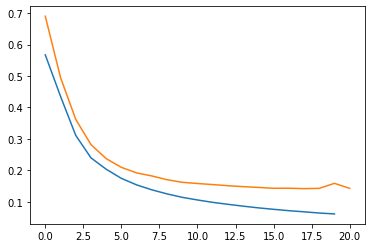

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(avg_train_losses)), avg_train_losses, avg_val_losses)

In [ ]:
def test_model(model):
    score = []
    for inputs, targets in test_dataloader:
        outputs = model.forward(inputs)
        preds = torch.sigmoid(outputs)
        score.append(roc_auc_score(targets, preds.detach().numpy()))
    return(np.mean(score))

In [ ]:
print('roc auc score on simple model:', test_model(model))

roc auc score on simple model: 0.9849565425701999


Модель уже показывает идеальное качество, что вообще подозрительно. Попробуем теперь обучить RNN:

## Эксперименты на более сложных моделях

In [ ]:
avg_train_losses = []
avg_val_losses = []
train_losses = []
val_losses = []
score = []

class LMwithReccurentLayer(LightningModule):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 1,
        aggregation_type: str = 'max',
        RNN: Union[nn.RNN, nn.LSTM, nn.GRU] = nn.LSTM,
        num_layers: int = 1,
        embedding_pretrained = None
        ):
        super().__init__()
        if embedding_pretrained == None:
          self.embedding = nn.Embedding(vocab_size, hidden_dim)
        else:
          self.embedding = nn.Embedding.from_pretrained(embedding_pretrained)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return torch.sigmoid(prediction)

    def training_step(self, batch, _):
        input, targets = batch
        preds = self.forward(input)

        loss_fn = nn.BCELoss()

        loss = loss_fn(preds, targets)
        train_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
      avg_train_losses.append(np.mean(train_losses))
      train_losses.clear()

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        preds = self.forward(inputs)
        loss_fn = nn.BCELoss()
        loss = loss_fn(preds, targets)
        val_losses.append(loss.item())
        return loss

    def on_validation_epoch_end(self):
      avg_val_losses.append(np.mean(val_losses))
      val_losses.clear()

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=3e-3)

        return optimizer

In [ ]:
max_epochs = 20

for rnn in [nn.RNN, nn.LSTM, nn.GRU]:
    for agg in ['max', 'mean']:
        trainer = Trainer(devices=1,max_epochs=max_epochs, log_every_n_steps=1)
        model = LMwithReccurentLayer(128, vocab_size, aggregation_type=agg, RNN=rnn)
        trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)
        print(f"roc_auc_score for {str(rnn)} with {agg} aggregation type: {test_model(model)}")

/home/alsu/.local/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/alsu/.local/lib/python3.8/site-packages/ipyke ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type      | Params
-----------------------------------------
0 | embedding  | Embedding | 621 K 
1 | rnn        | RNN       | 33.0 K
2 | linear     | Linear    | 16.5 K
3 | projection | Linear    | 129   
4 | non_lin    | Tanh      | 0     
5 | dropout    | Dropout   | 0     
-----------------------------------------
671 K     Trainable params
0         Non-trainable params
671 K     Total params
2.685     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
/home/alsu/.local/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/alsu/.local/lib/python3.8/site-packages/ipyke ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type      | Params
-----------------------------------------
0 | embedding  | Embedding | 621 K 
1 | rnn        | RNN       | 33.0 K
2 | linear     | Linear    | 16.5 K
3 | projection | Linear    | 129   
4 | non_lin    | Tanh      | 0     
5 | dropout    | Dropout   | 0     
-----------------------------------------
671 K     Trainable params
0         Non-trainable params
671 K     Total params
2.685     Total estimated model params size (MB)


roc_auc_score for <class 'torch.nn.modules.rnn.RNN'> with max aggregation type: 0.9836712681994274


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
/home/alsu/.local/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/alsu/.local/lib/python3.8/site-packages/ipyke ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type      | Params
-----------------------------------------
0 | embedding  | Embedding | 621 K 
1 | rnn        | RNN       | 33.0 K
2 | linear     | Linear    | 16.5 K
3 | projection | Linear    | 129   
4 | non_lin    | Tanh      | 0     
5 | dropout    | Dropout   | 0     
-----------------------------------------
671 K     Trainable params
0         Non-trainable params
671 K     Total params
2.685     Total estimated model params size (MB)


roc_auc_score for <class 'torch.nn.modules.rnn.RNN'> with mean aggregation type: 0.9704797724927986


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
/home/alsu/.local/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/alsu/.local/lib/python3.8/site-packages/ipyke ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type      | Params
-----------------------------------------
0 | embedding  | Embedding | 621 K 
1 | rnn        | RNN       | 33.0 K
2 | linear     | Linear    | 16.5 K
3 | projection | Linear    | 129   
4 | non_lin    | Tanh      | 0     
5 | dropout    | Dropout   | 0     
-----------------------------------------
671 K     Trainable params
0         Non-trainable params
671 K     Total params
2.685     Total estimated model params size (MB)


roc_auc_score for <class 'torch.nn.modules.rnn.LSTM'> with max aggregation type: 0.9902146274789031


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


roc_auc_score for <class 'torch.nn.modules.rnn.LSTM'> with mean aggregation type: 0.9683760091809664


/home/alsu/.local/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/alsu/.local/lib/python3.8/site-packages/ipyke ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type      | Params
-----------------------------------------
0 | embedding  | Embedding | 621 K 
1 | rnn        | RNN       | 33.0 K
2 | linear     | Linear    | 16.5 K
3 | projection | Linear    | 129   
4 | non_lin    | Tanh      | 0     
5 | dropout    | Dropout   | 0     
-----------------------------------------
671 K     Trainable params
0         Non-trainable params
671 K     Total params
2.685     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
/home/alsu/.local/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/alsu/.local/lib/python3.8/site-packages/ipyke ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type      | Params
-----------------------------------------
0 | embedding  | Embedding | 621 K 
1 | rnn        | RNN       | 33.0 K
2 | linear     | Linear    | 16.5 K
3 | projection | Linear    | 129   
4 | non_lin    | Tanh      | 0     
5 | dropout    | Dropout   | 0     
-----------------------------------------
671 K     Trainable params
0         Non-trainable params
671 K     Total params
2.685     Total estimated model params size (MB)


roc_auc_score for <class 'torch.nn.modules.rnn.GRU'> with max aggregation type: 0.9834900561483919


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


roc_auc_score for <class 'torch.nn.modules.rnn.GRU'> with mean aggregation type: 0.9649758457779208


Лучше всех себя показала LSTM с max аггрегацией. На тестовой выборке она показала реузльтат 0.9902146274789031. Посмотрим, увеличит ли показатели увеличение словев в LSTM.

### Увеличение слоев

In [ ]:
avg_train_losses = []
avg_val_losses = []
train_losses = []
val_losses = []
score = []

max_epochs = 3
trainer = Trainer(devices=1,max_epochs=max_epochs, log_every_n_steps=1)
model = LMwithReccurentLayer(128, vocab_size, aggregation_type='max', RNN=nn.LSTM, num_layers=2)
trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)

/home/alsu/.local/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/alsu/.local/lib/python3.8/site-packages/ipyke ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type      | Params
-----------------------------------------
0 | embedding  | Embedding | 621 K 
1 | rnn        | RNN       | 66.0 K
2 | linear     | Linear    | 16.5 K
3 | projection | Linear    | 129   
4 | non_lin    | Tanh      | 0     
5 | dropout    | Dropout   | 0     
-----------------------------------------
704 K     Trainable params
0         Non-trainable params
704 K     Total params
2.817     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/alsu/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
test_model(model)

0.9786856861835344

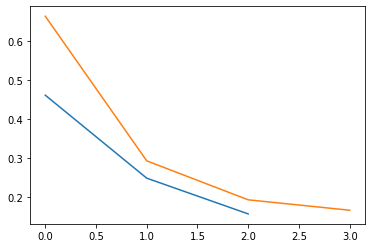

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(avg_train_losses)), avg_train_losses, avg_val_losses)

Я обучила на трех эпохах, иначе модель переобучалась. Видно, что увеличение слоев не помогло улучшить качество.

### Предобученные эмбеддинги

 Теперь попробуем вместо слоя эмбеддингов использовать предобученные эмбеддинги.

In [ ]:
!wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

--2024-05-03 17:38:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.19, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   117MB/s    in 8.3s    

2024-05-03 17:38:31 (152 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
from gensim.models import KeyedVectors

en_emb = KeyedVectors.load_word2vec_format("cc.en.300.vec")

In [ ]:
weights = torch.FloatTensor(en_emb.vectors)

In [ ]:
avg_train_losses = []
avg_val_losses = []
train_losses = []
val_losses = []
score = []

max_epochs = 20
trainer = Trainer(devices=1,max_epochs=max_epochs, log_every_n_steps=1)
model = LMwithReccurentLayer(300, vocab_size, aggregation_type='max', RNN=nn.LSTM, embedding_pretrained=weights)
trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | embedding  | Embedding | 600 M 
1 | rnn        | RNN       | 180 K 
2 | linear     | Linear    | 90.3 K
3 | projection | Linear    | 301   
4 | non_lin    | Tanh      | 0     
5 | dropout    | Dropout   | 0     
-----------------------------------------
271 K     Trainable params
600 M     Non-trainable params
600 M     Total params
2,401.085 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


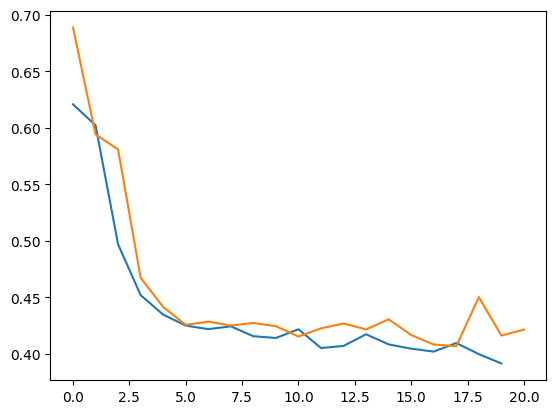

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(avg_train_losses)), avg_train_losses, avg_val_losses)

In [ ]:
test_model(model)

0.8853877615201216

Видим, что это не помогло.

###  Лучшая модель
Тогда остановимся на LSTM с max аггрегацией.



In [ ]:
avg_train_losses = []
avg_val_losses = []
train_losses = []
val_losses = []
score = []

max_epochs = 20
trainer = Trainer(devices=1,max_epochs=max_epochs, log_every_n_steps=1)
model = LMwithReccurentLayer(128, vocab_size, aggregation_type='max', RNN=nn.LSTM)
trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | embedding  | Embedding | 621 K 
1 | rnn        | RNN       | 33.0 K
2 | linear     | Linear    | 16.5 K
3 | projection | Linear    | 129   
4 | non_lin    | Tanh      | 0     
5 | dropout    | Dropout   | 0     
-----------------------------------------
671 K     Trainable params
0         Non-trainable params
671 K     Total params
2.685     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
test_model(model)

0.9815705880083072

## Предсказания на тесте

Теперь получим предсказания для теста. Предобработаем тестовые данные так же, как и данные для обучения.

In [ ]:
test_data = pd.read_csv('test_spam.csv')

In [ ]:
tokenized_test_data = tokenize_text(test_data)

  0%|          | 0/4070 [00:00<?, ?it/s]

In [ ]:
X_test = TextsForLM(tokenized_test_data)

  0%|          | 0/4070 [00:00<?, ?it/s]

In [ ]:
X_test = collate_texts(X_test)

In [ ]:
test_data = torch.tensor(X_test, dtype=torch.int)

<ipython-input-62-e2fc4f689c2d>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_data, dtype=torch.int)


Получим предсказания:

In [ ]:
output = model.forward(test_data)
output = [pred.item() for pred in output]

Создадим датасет:

In [ ]:
test_preds = pd.DataFrame({'score':pd.Series(output), 'text':test_data['text']})

Ради интереса посмотрим на прдесказания:

In [ ]:
test_preds['text'][908]

'risk 2000 boston dear vince i apologise for sending another email i was wondering if you could confirm your talk title plus some bullet points for your presentation at our annual us congress i have attached a condensed programme for the event you are speaking on stream three part of the new research in derivatives modelling and analysis section unfortunately we are printing the brochure at the end of the week and will need these details by thursday 27 january best regards oliver direct 44 171 484 9880 risk publications 28 29 haymarket london swly 4 rx fax 44 171 484 9800 email conf ny msn com www riskpublications com attl htm condensed doc'

In [ ]:
test_preds['score'][908]

3.7568457855741144e-07

Сохраним файл:

In [ ]:
test_preds.to_csv("test_preds.csv")